In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from model import RedCNN
from customDataset import CatdogDataset
import cv2
from misc import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import statistics

from PIL import Image
from IPython.display import display
import warnings
from sklearn.preprocessing import normalize
warnings.filterwarnings('ignore')

In [2]:
gtpath="../dogData_60/gt/"
gtfiles=[]
for folder, subfolder, filenames in os.walk(gtpath):
    for files in filenames:
        gtfiles.append(files)
        

noisepath="../dogData_60/noise/"
noisefiles=[]
for folder, subfolder, filenames in os.walk(noisepath):
    for files in filenames:
        noisefiles.append(files)
        
#check whether both noise and gt have same files
print(gtfiles==noisefiles)
gtfiles_=gtfiles[:1000]

True


In [3]:
m2dataset= CatdogDataset(data_path=noisepath,target_path=gtpath,filenames=gtfiles_)
train_size=int(0.7*len(m2dataset))
test_size=len(m2dataset)-train_size
trainset,testset=random_split(m2dataset,[train_size,test_size],generator=torch.manual_seed(42))


In [4]:
model_dog=RedCNN()
model_dog.load_state_dict(torch.load("./saved_models/task1_model.pth.tar"))
print(model_dog)
criterion=nn.MSELoss()
optimizer = torch.optim.Adam(model_dog.parameters(), lr=0.0001)

RedCNN(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_output): ConvTranspose2d(96, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [5]:
##Training
optimizer.zero_grad()


train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)


losses_batch=[]
trained_psnr=[]
psnr=[]
for epoch in range(2):
    
    for i, data in enumerate(train_loader):

        inputt, target=data

        target_pred=model_dog(inputt)
        
        img=inputt.detach().numpy()
        img_gt=target.detach().numpy()
        recon_image=target_pred.detach().numpy()
        
        
        for j in range(len(target)):
            psnr.append(cv2.PSNR(img[j],img_gt[j]))
            trained_psnr.append(cv2.PSNR(img[j],recon_image[j]))

        loss=criterion(target_pred,target)


        losses_batch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch:{epoch} Loss:{loss.item()} Batch:{i}")


Epoch:0 Loss:1364.684326171875 Batch:0
Epoch:0 Loss:1269.7813720703125 Batch:1
Epoch:0 Loss:1265.136962890625 Batch:2
Epoch:0 Loss:1196.4456787109375 Batch:3
Epoch:0 Loss:1252.85693359375 Batch:4
Epoch:0 Loss:1178.44384765625 Batch:5
Epoch:0 Loss:1184.54345703125 Batch:6
Epoch:0 Loss:1130.0704345703125 Batch:7
Epoch:0 Loss:1113.8204345703125 Batch:8
Epoch:0 Loss:1095.7957763671875 Batch:9
Epoch:0 Loss:1055.858642578125 Batch:10
Epoch:0 Loss:1037.423095703125 Batch:11
Epoch:0 Loss:1048.117431640625 Batch:12
Epoch:0 Loss:1010.3289794921875 Batch:13
Epoch:0 Loss:1084.6556396484375 Batch:14
Epoch:0 Loss:1025.2269287109375 Batch:15
Epoch:0 Loss:978.082275390625 Batch:16
Epoch:0 Loss:1020.5698852539062 Batch:17
Epoch:0 Loss:995.4302978515625 Batch:18
Epoch:0 Loss:999.9973754882812 Batch:19
Epoch:0 Loss:987.63232421875 Batch:20
Epoch:0 Loss:950.0584716796875 Batch:21
Epoch:1 Loss:944.0302734375 Batch:0
Epoch:1 Loss:923.8934326171875 Batch:1
Epoch:1 Loss:901.3576049804688 Batch:2
Epoch:1 Loss:

In [7]:

trained_psnrfile="./psnr_data/task2noewc_by_task2noewc_trainfiles.pth.tar"
psnr_file="./psnr_data/task2noewc_trainfiles.pth.tar"
loss_file="./saved_loss/task2noewc_loss.pth.tar"

torch.save(trained_psnr,trained_psnrfile)
torch.save(psnr,psnr_file)
torch.save(losses_batch,loss_file)
modelfile="./saved_models/task2noewc_model.pth.tar"

torch.save(model_dog.state_dict(),modelfile)

# Model Diagnostics

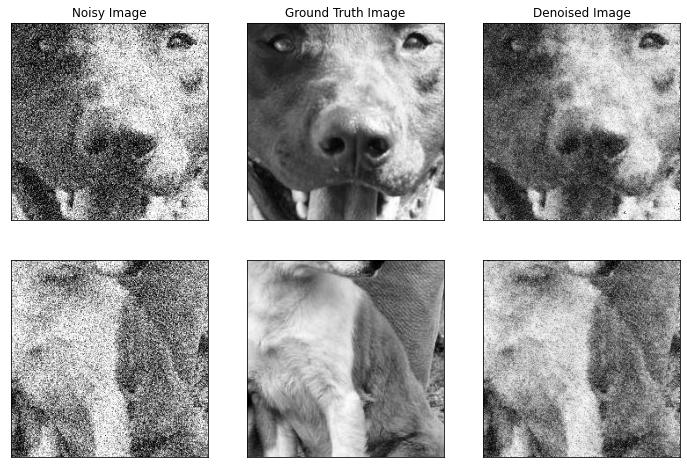

In [10]:
check_images(trainset[110],testset[9],model_dog)

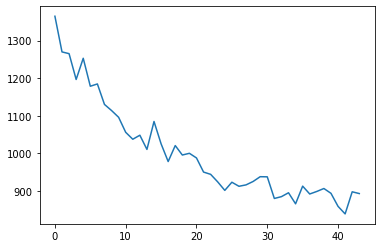

In [12]:
#plopling the loss vs batch
plt.plot(list(range(44)),losses_batch)

In [15]:
##PSNR of training data
print(f"PSNR Training Set: {statistics.mean(psnr)}")
print(f"PSNR after applying the model: {statistics.mean(trained_psnr)}")

PSNR Training Set: 13.381423840721473
PSNR after applying the model: 20.000623344071105


In [16]:
##PSNR of test data
test_psnrfile="./psnr_data/task2noewc_testfiles.pth.tar"
test_modelpsnrfile="./psnr_data/task2noewc_by_task2noewc_testfiles.pth.tar"

test1_psnr=gt_psnr(testset)
test_modelpsnr=test_psnr(testset,model_dog)

torch.save(test1_psnr,test_psnrfile)
torch.save(test_modelpsnr,test_modelpsnrfile)

PSNR test set: 13.361490453879417
PSNR after model: 13.786355420197612
